In [2]:
from multiprocessing import cpu_count
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import nltk
import vk
import matplotlib.pyplot as plt
import urllib.request
import numpy as np
from PIL import Image
from IPython.display import clear_output
import re
import json
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
%matplotlib inline
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dimao\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
token = "9cad73ddf0088749120e2376c2dfcd1a8d89a26b42a3e0e39b3a47833247525e63f4a18b27f41b46d409d"

lemmatizer = nltk.stem.WordNetLemmatizer()

cores = cpu_count()

In [3]:
def get_groups():
    session = vk.Session(token)
    api = vk.API(session)
    try:
        json_response = api.groups.search(q="a", type="page", count="1000", v="5.131", sort="6")
        return json_response['items']
    except Exception as ex:
        print(ex)

def get_mean_reposts(posts):
    mean_reposts = 0
    for i in range(len(posts)):
        mean_reposts += posts[i]['reposts']['count']
    mean_reposts = mean_reposts / len(posts)
    return mean_reposts

def get_posts(group_id, count, offset):
    session = vk.Session(token)
    api = vk.API(session)
    try:
        json_response = api.wall.get(owner_id=-group_id, count=count, offset=offset, v="5.131")
        posts = json_response['items']
        mean_reposts = get_mean_reposts(posts)
        for i in range(len(posts)):
            posts[i]['virality'] = (posts[i]['reposts']['count'] / mean_reposts) * 1000
        return posts
    except Exception as ex:
        print(ex)

In [4]:
groups = get_groups()
groups = groups[:100]

In [5]:
posts = []
for i in range(len(groups)):
    posts = posts + get_posts(groups[i]['id'], 100, 5)

Предобработка

In [6]:
dfc = pd.DataFrame(posts).to_dict('list')

In [15]:
def first_photo_average_colour(attachments):
    try:
        if attachments != None and attachments == attachments:
            photos = list(filter(lambda x: x['type']=='photo', attachments))
            if any(photos):
                url = photos[0]['photo']['sizes'][-1]['url']
                urllib.request.urlretrieve(url, "temp.png")
                img = np.asarray(Image.open('temp.png'))
                average_colour_row = np.average(img, axis=0)
                average_colour = np.average(average_colour_row, axis=0)
                return list(average_colour)
        return [0, 0, 0]
    except:
        return [0, 0, 0]

colours = []
for i in range(len(dfc['attachments'])):
    colours = colours + [first_photo_average_colour(dfc['attachments'][i])]

In [11]:
def get_word_count(text):
    text = text.lower()
    text = re.sub("[^A-Za-zА-Яа-я]", " ", text)
    text = word_tokenize(text)
    return(len(text))

word_counts = []
for i in range(len(dfc['text'])):
    word_counts = word_counts + [get_word_count(dfc['text'][i])]

In [10]:
def get_photo_count(attachments):
    if attachments != None and attachments == attachments:
        photos = list(filter(lambda x: x['type']=='photo', attachments))
        return(len(photos))
    return 0

picture_counts = []
for i in range(len(dfc['attachments'])):
    picture_counts = picture_counts + [get_photo_count(dfc['attachments'][i])]

In [9]:
def get_video_count(attachments):
    if attachments != None and attachments == attachments:
        videos = list(filter(lambda x: x['type']=='video', attachments))
        return(len(videos))
    return 0

video_counts = []
for i in range(len(dfc['attachments'])):
    video_counts = video_counts + [get_video_count(dfc['attachments'][i])]

In [13]:
def get_audio_count(attachments):
    if attachments != None and attachments == attachments:
        audios = list(filter(lambda x: x['type']=='audio', attachments))
        return(len(audios))
    return 0

audio_counts = []
for i in range(len(dfc['attachments'])):
    audio_counts = audio_counts + [get_audio_count(dfc['attachments'][i])]

In [14]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub("[^A-Za-zА-Яа-я]", " ", text)
    text = word_tokenize(text)
    text = [word for word in text if word not in set(nltk.corpus.stopwords.words("russian"))]
    text = [lemmatizer.lemmatize(word) for word in text]
    return text

texts = []
for i in range(len(dfc['text'])):
    texts = texts + [preprocess_text(dfc['text'][i])]

In [ ]:
print(dfc.keys())
dfc['views'][2]

dict_keys(['id', 'from_id', 'owner_id', 'date', 'marked_as_ads', 'is_favorite', 'post_type', 'text', 'attachments', 'comments', 'likes', 'reposts', 'views', 'donut', 'short_text_rate', 'carousel_offset', 'edited', 'hash', 'virality', 'copyright', 'zoom_text', 'copy_history', 'signer_id'])


{'count': 136770}

In [16]:
data = {}
data['text'] = texts
data['photo'] = picture_counts
data['video'] = video_counts
data['audio'] = audio_counts
data['colour'] = colours
data['words'] = list(map(lambda x: len(x), texts))
data['likes'] = list(map(lambda x: x['count'], dfc['likes']))
data['reposts'] = list(map(lambda x: x['count'], dfc['reposts']))
data['views'] = list(map(lambda x: x['count'], dfc['views']))
data['comments'] = list(map(lambda x: x['count'], dfc['comments']))
data['virality'] = dfc['virality']

with open('data.json', 'w') as file:
    json.dump(data, file)

Считывание из файла

In [3]:
with open('data.json', 'r') as file:
    data2 = json.load(file)

data2['colour'] = list(map(lambda x: [0, 0, 0] if x == None else x, data2['colour']))
data2['text'] = list(map(lambda x: ' '.join(x), data2['text']))

In [4]:
vect = CountVectorizer(ngram_range=(1,3))

train_index = []
test_index = []
loaded_data = pd.DataFrame(data2)
colours = pd.DataFrame(list(loaded_data['colour']), columns=["red", "green", 'blue'])
vectorizer = CountVectorizer(ngram_range=(1,1))
vectorized_texts = vectorizer.fit_transform(data2['text'])
vocabulary = list(map(lambda x: 'word_' + x, vectorizer.get_feature_names_out()))

for i in loaded_data.index:
    result = np.random.choice(2, p=[.65,.35])
    if result == 1:
        test_index.append(i)
    else:
        train_index.append(i)

y_train = loaded_data.iloc[train_index]['virality'].astype(int)
x_train = loaded_data.iloc[train_index][['photo', 'video', 'audio', 'words']]
x_train = pd.merge(x_train, pd.DataFrame(vectorized_texts[train_index].toarray(), index=x_train.index, columns=vocabulary), left_index=True, right_index=True)
x_train = pd.merge(x_train, colours, left_index=True, right_index=True)

y_test = loaded_data.iloc[test_index]['virality'].astype(int)
x_test = loaded_data.iloc[test_index][['photo', 'video', 'audio', 'words']]
x_test = pd.merge(x_test, pd.DataFrame(vectorized_texts[test_index].toarray(), index=x_test.index, columns=vocabulary), left_index=True, right_index=True)
x_test = pd.merge(x_test, colours, left_index=True, right_index=True)

x_train
y_actual = y_test

In [5]:
x_train

,photo,video,audio,words,word_aa,word_aao,word_ab,word_abc,word_abola,word_abwauy,...,word_ясно,word_ясным,word_яхте,word_ячмень,word_ячменя,word_ящик,word_ящикoв,red,green,blue
0,3,1,0,30,0,0,0,0,0,0,...,0,0,0,0,0,0,0,135.270697,135.641027,141.126871
1,1,3,0,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,119.864314,94.665178,77.405878
3,2,2,0,84,0,0,0,0,0,0,...,0,0,0,0,0,0,0,104.787349,81.677017,56.275102
4,3,0,0,34,0,0,0,0,0,0,...,0,0,0,0,0,0,0,122.265034,106.368080,111.867143
6,0,1,0,51,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,1,0,0,10,0,0,0,0,0,0,...,0,0,0,0,0,0,0,98.508189,70.928720,70.573112
9992,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,112.452995,125.114325,99.990411
9995,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,68.268220,39.194006,47.581326
9996,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.000000,0.000000,0.000000


Random forest

In [ ]:
#rf = RandomForestRegressor(n_estimators=1000, verbose=True)
#rf.fit(x_train, y_train)

c:\Users\dimao\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed: 15.7min finished


RandomForestRegressor(n_estimators=1000, verbose=True)

In [ ]:
#rf_y_pred = rf.predict(x_test)

#rf_deltas = pd.DataFrame(list(zip(rf_y_pred, y_actual, (rf_y_pred -
#y_actual)/(y_actual))), columns=['predicted', 'actual', 'delta'])

XGBoost

In [ ]:
xgb = XGBRegressor()
xgb.fit(x_train, y_train)

In [20]:
xgb_y_pred = xgb.predict(x_test)

xgb_deltas = pd.DataFrame(list(zip(xgb_y_pred, y_actual, (xgb_y_pred -
y_actual)/(y_actual))), columns=['predicted', 'actual', 'delta'])

CatBoost

In [6]:
cb = CatBoostRegressor()
cb.fit(x_train, y_train, verbose=False)

In [7]:
cb_y_pred = cb.predict(x_test)

cb_deltas = pd.DataFrame(list(zip(cb_y_pred, y_actual, (cb_y_pred -
y_actual)/(y_actual))), columns=['predicted', 'actual', 'delta'])


SVR

In [ ]:
svr = SVR()
svr.fit(x_train, y_train)

In [ ]:
svr_y_pred = svr.predict(x_test)

svr_deltas = pd.DataFrame(list(zip(svr_y_pred, y_actual, (svr_y_pred -
y_actual)/(y_actual))), columns=['predicted', 'actual', 'delta'])

MPL

In [ ]:
mpl = MLPRegressor()
mpl.fit(x_train, y_train)

In [ ]:
mpl_y_pred = mpl.predict(x_test)

mpl_deltas = pd.DataFrame(list(zip(mpl_y_pred, y_actual, (mpl_y_pred -
y_actual)/(y_actual))), columns=['predicted', 'actual', 'delta'])

Вывод

In [8]:
#print(f"Random forest = {np.sqrt(np.mean((rf_y_pred-y_actual)**2))/np.mean(y_actual)}")
#print(f"XGBoost = {np.sqrt(np.mean((xgb_y_pred-y_actual)**2))/np.mean(y_actual)}")
print(f"CatBoost = {np.sqrt(np.mean((cb_y_pred-y_actual)**2))/np.mean(y_actual)}")
#print(f"SVR = {np.sqrt(np.mean((svr_y_pred-y_actual)**2))/np.mean(y_actual)}")
#print(f"MPL = {np.sqrt(np.mean((mpl_y_pred-y_actual)**2))/np.mean(y_actual)}")

CatBoost = 1.8893175193698564


График

<AxesSubplot:>

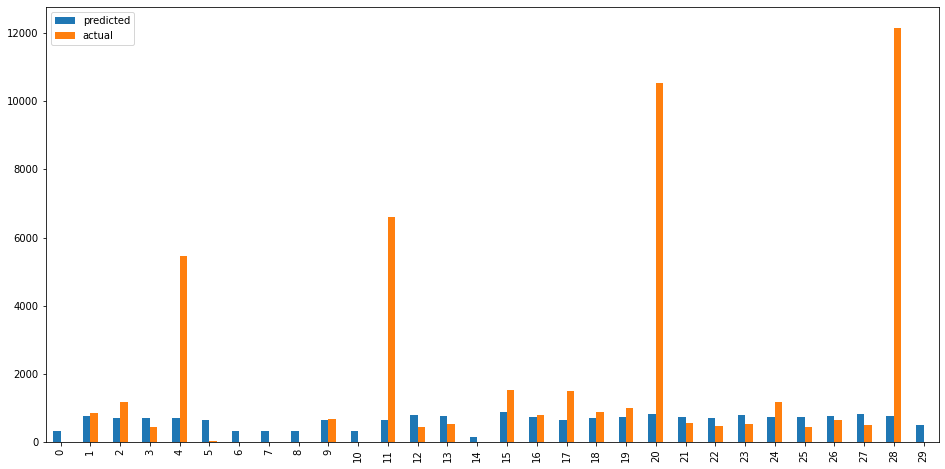

In [9]:
cb_deltas[['predicted','actual']].iloc[:30,:].plot(kind='bar', figsize=(16,8))

Выгрузка

In [10]:
cb.save_model("model")